# Work 5: Pegasus-large fine-tuned on Extracted HUPD Sample

Extractive summaries (SumBasic, extracted from Description and Claims sections), are used as input ids and abstract as label when fine-duning Pegasus-large.

## Setup

In [ ]:
#install libraries
!pip install -q datasets
!pip install -q transformers
!pip install --quiet --upgrade accelerate
!pip install -q sentencepiece
!pip install -q evaluate
!pip install -q rouge_score
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Install Packages

#standard data science libraries
import pandas as pd
import numpy as np
import random

#visualization
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display, HTML

#datasets
import datasets
from datasets import load_from_disk
from datasets import load_dataset, load_metric

#transformers
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import TrainingArguments
from transformers import AutoTokenizer

# PyTorch
import torch

#rouge
import evaluate
from evaluate import load

#nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
##### ensure you mount to the folder that you want.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_save_dir="/content/drive/MyDrive/W266/HUPD"
model_save_dir="/content/drive/MyDrive/W266/ProjectModels/Pegasus_large_ft_extracted"

Mounted at /content/drive


##Load Data

In [ ]:
##########################for the test on small data
dataset = load_from_disk(data_save_dir + '/extracted_train_sample_cd')

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)

In [ ]:
val_test_split = dataset['test'].train_test_split(test_size=0.5)

In [ ]:
dataset['train'] = dataset['train']
dataset['val'] = val_test_split['train']
dataset['test'] = val_test_split['test']

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 576
    })
    test: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 72
    })
    val: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 72
    })
})

In [ ]:
#only run if you want to shrink the amount of data you are working with.
# train_set = train_set.shuffle(seed=42).select(range(1000))
# val_set = val_set.shuffle(seed=42).select(range(100))
# test_set = test_set.shuffle(seed=42).select(range(100))

# Modeling

In [ ]:
model_checkpoint = "google/pegasus-large"

In [ ]:
metric = load('rouge')

### Tokenize Data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
max_input_length = 500 #oof this wouldn't get any higher or colab would crash... I sure love colab <3
max_summary_length = 100

In [ ]:
def preprocess_text(dataset, summarize_section = 'extractive_summaries'):
  inputs = dataset[summarize_section]
  model_inputs  = tokenizer(inputs, truncation = True, max_length = max_input_length) #, return_tensors = 'pt', , padding = 'max_length'
  labels = dataset['abstract']
  model_labels = tokenizer(text_target = labels, truncation = True, max_length = max_input_length) #, return_tensors = 'pt' , padding = 'max_length'
  model_inputs['labels'] = model_labels['input_ids']
  return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_text, batched=True)

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

### Set up Model and Fine Tune

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
batch_size = 2
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-extracted-summarization",
    evaluation_strategy = "epoch",
    learning_rate=10e-5,#also tried 5e-5 and 2e-5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01, #to reduce observed overfit
    save_total_limit=6,
    num_train_epochs=5, #also tried 5 and 6
    predict_with_generate=True,
    fp16=True
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value for key, value in result.items()} #(took out *100)

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.012622,0.270100,0.122000,0.219100,0.218900,206.527800
2,2.203900,1.984347,0.254900,0.118200,0.210500,0.204500,226.486100
3,2.203900,1.981746,0.270700,0.128700,0.223900,0.221600,215.597200
4,1.750600,1.995061,0.270800,0.118700,0.221300,0.220900,203.097200
5,1.750600,2.008345,0.293500,0.142100,0.241000,0.243900,189.250000


TrainOutput(global_step=1440, training_loss=1.8595059288872613, metrics={'train_runtime': 2473.1587, 'train_samples_per_second': 1.165, 'train_steps_per_second': 0.582, 'total_flos': 4063309332480000.0, 'train_loss': 1.8595059288872613, 'epoch': 5.0})

In [ ]:
val_loss = {trainer.state.log_history[i]['epoch']:trainer.state.log_history[i]['eval_loss'] for i in [0,2,3,5,6,8]}

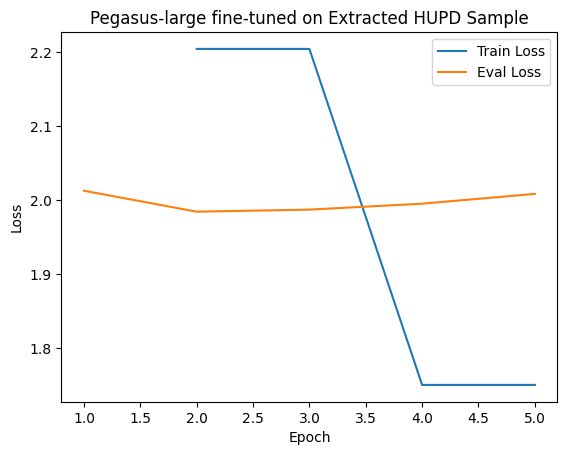

In [ ]:
# prompt: plot two dictionarries as two lines, one with structure {epoch: eval_loss} the other with structure {epoch:loss}. Plot both lines on the same chart.

val_loss = {1:2.0126, 2:1.9843, 3:1.9871, 4:1.9951, 5:2.0083}
train_loss = {2:2.2039, 3:2.2039, 4:1.7506, 5:1.7506}
plt.plot(train_loss.keys(), train_loss.values(), label = train_loss)
plt.plot(val_loss.keys(), val_loss.values(), label = val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pegasus-large fine-tuned on Extracted HUPD Sample')
plt.legend(['Train Loss', 'Eval Loss'])
plt.show()


In [ ]:
trainer.evaluate()

In [ ]:
test_predictions = trainer.predict(
                test_dataset = tokenized_dataset['test'],
                num_beams = 12,
                max_length = max_summary_length
                )

In [ ]:
test_predictions.metrics

{'test_loss': 2.0557966232299805,
 'test_rouge1': 0.2966,
 'test_rouge2': 0.1334,
 'test_rougeL': 0.2342,
 'test_rougeLsum': 0.2509,
 'test_gen_len': 86.0417,
 'test_runtime': 151.5993,
 'test_samples_per_second': 0.475,
 'test_steps_per_second': 0.237}

In [ ]:
summarized_texts = []
for summary in test_predictions.predictions:
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.append(summarized_text)

In [ ]:
random_indices = [ 4, 62, 18,  0, 28, 50, 10, 34, 12, 54]

# num_examples = 10
# random_indices = np.random.choice(len(tokenized_dataset['test']), num_examples, replace=False)
# print(random_indices)

In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [tokenized_dataset['test']['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,"[<pad>, The, present, invention, relates, to, a, process, for, producing, methyl, meth, acrylate, (, MMA, ), from, me, tha, cro, lein, (, MAC, ),, methanol, ,, and, oxygen, ., The, process, is, capable, of, producing, und, es, ir, ably, high, amounts, of, methyl, for, mate, as, a, by, -, product, ., The, present, invention, relates, to, a, process, for, producing, methyl, meth, acrylate, (, MMA, ), from, me, tha, cro, lein, (, MAC, ),, methanol, ,, and, oxygen, ., The, process, is, capable, of, producing, und, es, ir, ably, high, amounts, of, methyl, for, mate, as, a, by, -, </s>, ...]","A process for producing methyl methacrylate, the process comprising contacting reactants comprising methacrolein, methanol and an oxygen-containing gas, under reaction conditions in the presence of a solid catalyst comprising palladium, bismuth and at least one third element X selected from the group consisting of Fe, Zn, Ge, and Pb, wherein the solid catalyst further comprises a support selected from at least one member of the group consisting of silica and alumina."
1,"[<pad>, The, present, invention, provides, compounds, of, formula, (, I, ), wherein, R, 1, is, C, 1-6, alkyl, ;, R, 2, is, , phenyl, ,, which, is, once, or, twice, or, three, times, substituted, by, halogen, or, C, 1-6, alkyl, ;, R, 3, is, hydrogen, or, C, 1-6, alkyl, ;, R, 4, is, wherein, one, of, R, 5, a, and, R, 6, a, is, hydrogen, or, halogen, ,, and, the, other, one, is, hydrogen, ,, halogen, or, , hydroxy, ;, one, of, R, 5, b, and, R, 6, b, is, hydrogen, or, halogen, ,, and, the, other, one, is, </s>, ...]","The invention provides novel compounds having the general formula: wherein R1, R2, R3 and R4 are as defined in the description and in the claims, as well as or pharmaceutically acceptable salts, or tautomerism isomers, or enantiomers, or diastereomers thereof. The invention also contains compositions including the compounds and methods of using the compounds."
2,"[<pad>, A, method, for, treating, or, preventing, pre, diabetes, or, diabetes, comprising, administering, to, a, subject, in, need, thereof, a, therapeutic, ally, effective, amount, of, a, compound, selected, from, the, group, consisting, of, 2-, (, (3, -, (, 5-, chloro, -2-, (2, -, chloro, -5, -, fluoro, -4, -, (, N, -, (, thia, zol, -2-, yl, ), s, ulf, amo, yl, ), phenyl, ), propyl, )(, propyl, ), amino, ), acetic, acid, ,, 2-, (, ally, l, (3, -, (, 5-, chloro, -2-, (2, -, chloro, -5, -, fluoro, -4, -, (, N, -, (, thia, zol, -2-, </s>, ...]","Provided herein are sodium channel modulating Compounds, in particular NaV1.7 modulating compounds of Formula I or compounds of Formula I′: In particular, provided herein are processes for the preparation of, intermediates used in the preparation of, pharmaceutical compositions comprising, and therapeutic methods comprising administering such compounds. In particular, provided herein are compounds for the treatment of pain and diabetes."
3,"[<pad>, An, anticancer, agent, containing, a, cDNA, consisting, of, a, partial, region, of, a, REI, C, /, D, kk, -3, cDNA, ,, which, consists, of, the, nucleotide, sequence, shown, in, SE, Q, ID, NO, :, 8, or, a, vector, comprising, a, cDNA, consisting, of, a, partial, region, of, a, REI, C, /, D, kk, -3, cDNA, ,, which, consists, of, the, nucleotide, sequence, shown, in, SE, Q, ID, NO, :, 8, and, a, hetero, log, ous, promoter, and, /, or, as, an, active, ingredient, ., </s>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, ...]","A polypeptide capable of strongly inducing and activating dendritic-cell-like cells for treating or prevent cancer by immunotherapy, and DNA encoding the polypeptide. The polypeptide is a polypeptide (a) or (b) consisting of a partial region of the REIC/Dkk-3 protein."
4,"[<pad>, Dis, closed, herein, are, human, ized, monoclonal, antibodies, that, specifically, bind, to, herpes, zo, ster, virus, (, J, EV, )., The, antibodies, 

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()